### Zomato Data Analysis Project

IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from sklearn.cluster import KMeans
from textblob import TextBlob
from wordcloud import WordCloud
import ipywidgets as widgets
from IPython.display import display

### Load and Clean Column Name

In [2]:
df = pd.read_csv("Zomato.csv")

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [3]:
# Convert 'rate'
def handle_rate(value):
    try:
        return float(str(value).split('/')[0])
    except:
        return np.nan
df['rate'] = df['rate'].apply(handle_rate)

# Clean 'approx_cost_for_two_people'
df['approx_costfor_two_people'] = df['approx_costfor_two_people'].astype(str).str.replace(',', '').astype(float)

# Clean 'votes'
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')

In [4]:
# Replace hidden empties and malformed entries across the entire DataFrame
df.replace(["", "[]", "nan", "NaN", "NAN"], np.nan, inplace=True)

# Clean 'rate' column: remove '/5', convert to float, drop rows with invalid ratings
df['rate'] = df['rate'].astype(str).str.replace("/5", "").str.strip()
df['rate'] = df['rate'].replace("NEW", np.nan).replace("-", np.nan)
df['rate'] = pd.to_numeric(df['rate'], errors='coerce')

# Clean 'approx_costfor_two_people': remove commas, convert to float
df['approx_costfor_two_people'] = df['approx_costfor_two_people'].astype(str).str.replace(",", "")
df['approx_costfor_two_people'] = pd.to_numeric(df['approx_costfor_two_people'], errors='coerce')

# Fill missing values
df['rate'] = df['rate'].fillna(df['rate'].median())
df['approx_costfor_two_people'] = df['approx_costfor_two_people'].fillna(df['approx_costfor_two_people'].median())
df['phone'] = df['phone'].fillna("Not Provided")
df['location'] = df['location'].fillna(df['location'].mode()[0])
df['rest_type'] = df['rest_type'].fillna(df['rest_type'].mode()[0])
df['cuisines'] = df['cuisines'].fillna(df['cuisines'].mode()[0])
df['dish_liked'] = df['dish_liked'].fillna("Not Mentioned")
df['reviews_list'] = df['reviews_list'].fillna("No Reviews")

# Final cleanup: drop any remaining rows with nulls (if critical columns still have them)
df.dropna(inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

### Handle Missing Value

Missing Values per Column:
url                          0
address                      0
name                         0
online_order                 0
book_table                   0
rate                         0
votes                        0
phone                        0
location                     0
rest_type                    0
dish_liked                   0
cuisines                     0
approx_costfor_two_people    0
reviews_list                 0
menu_item                    0
listed_intype                0
listed_incity                0
dtype: int64


Data Types:
url                           object
address                       object
name                          object
online_order                  object
book_table                    object
rate                         float64
votes                          int64
phone                         object
location                      object
rest_type                     object
dish_liked                    object
cuisines    

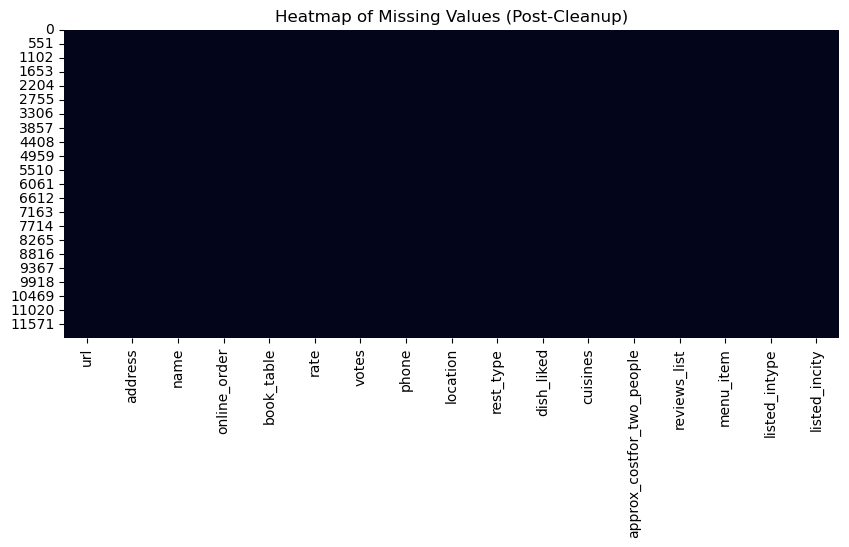

In [5]:
# Check for missing values
print("Missing Values per Column:")
print(df.isnull().sum())
print("\n")

# Check data types
print("Data Types:")
print(df.dtypes)
print("\n")

# Check for duplicates
print("Duplicate Rows:", df.duplicated().sum())
print("\n")

# Check value ranges for numeric columns
print("Rate Summary:")
print(df['rate'].describe())
print("\n")

print("Approx Cost for Two Summary:")
print(df['approx_costfor_two_people'].describe())
print("\n")

# Check unique categories for key categorical columns
print("Sample Unique Locations:", df['location'].unique()[:10])
print("Sample Unique Rest Types:", df['rest_type'].unique()[:10])
print("Sample Unique Cuisines:", df['cuisines'].unique()[:10])
print("\n")

# Check consistency of Yes/No columns
if 'online_order' in df.columns:
    print("Online Order Values:", df['online_order'].value_counts())
if 'book_table' in df.columns:
    print("Book Table Values:", df['book_table'].value_counts())

# Visual check for missing values
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Heatmap of Missing Values (Post-Cleanup)")
plt.show()

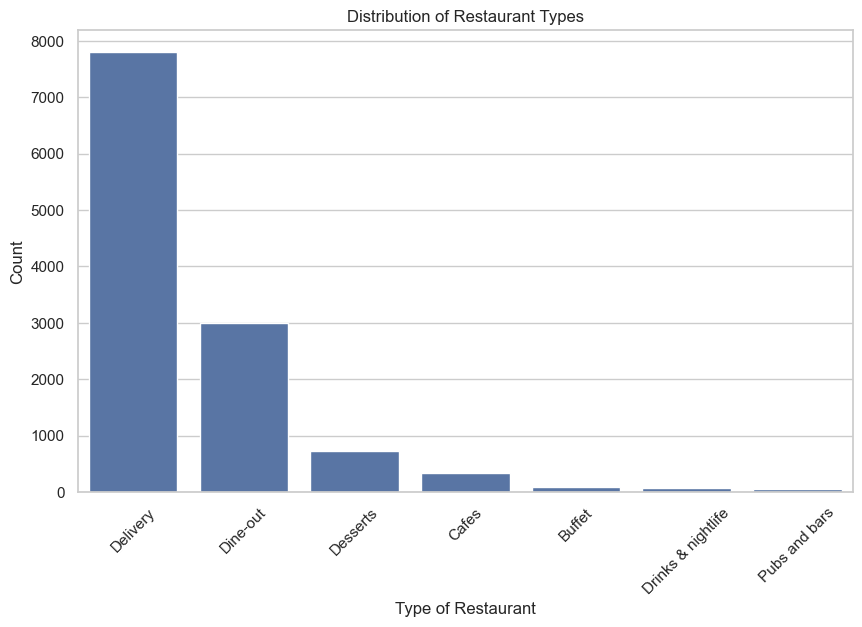

In [6]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.countplot(x=df['listed_intype'], order=df['listed_intype'].value_counts().index)
plt.xlabel("Type of Restaurant")
plt.ylabel("Count")
plt.title("Distribution of Restaurant Types")
plt.xticks(rotation=45)
plt.show()

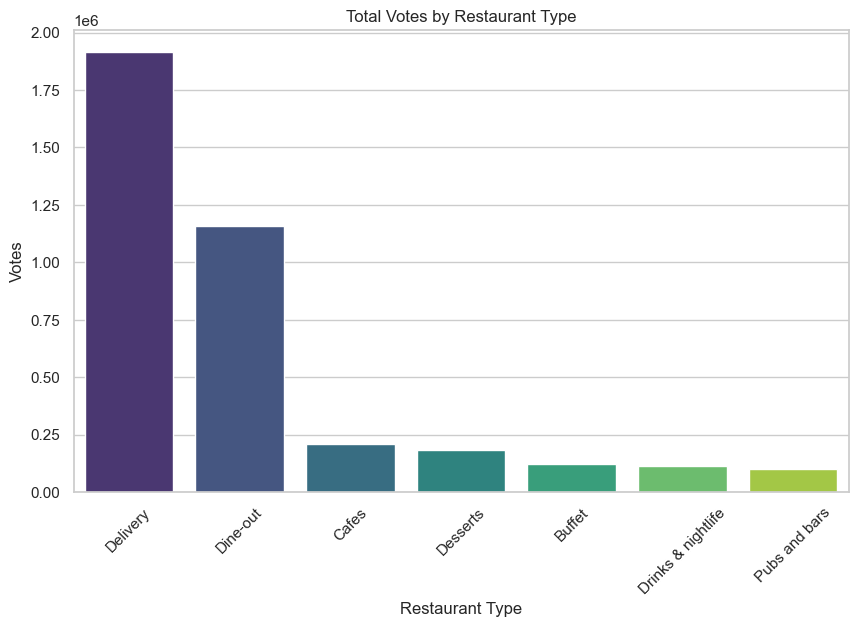

In [7]:
grouped_votes = df.groupby('listed_intype')['votes'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=grouped_votes.index, 
            y=grouped_votes.values, 
            hue=grouped_votes.index,   # Explicitly assign hue
            palette="viridis", 
            legend=False)              # Hide redundant legend
plt.xticks(rotation=45)
plt.title("Total Votes by Restaurant Type")
plt.ylabel("Votes")
plt.xlabel("Restaurant Type")
plt.show()

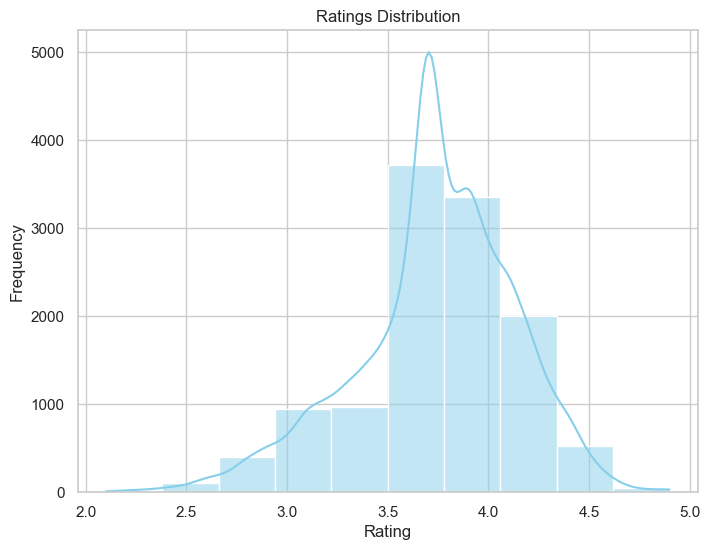

In [8]:
plt.figure(figsize=(8,6))
sns.histplot(df['rate'], bins=10, kde=True, color="skyblue")
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

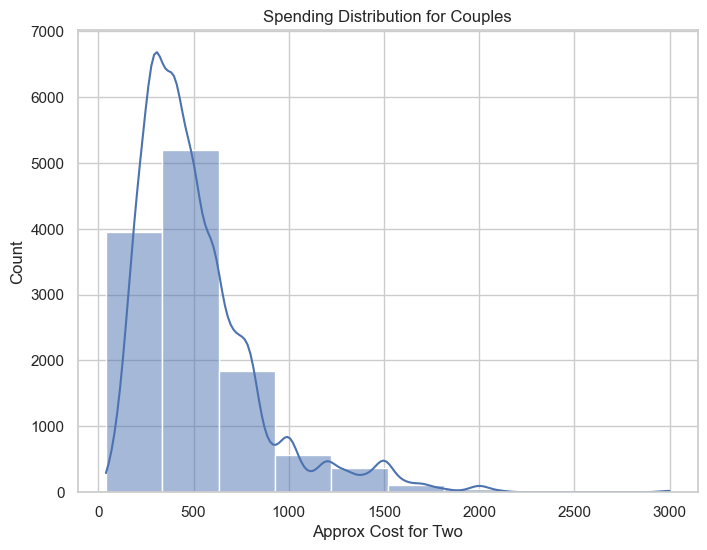

In [9]:
plt.figure(figsize=(8,6))
sns.histplot(df['approx_costfor_two_people'], bins=10, kde=True)
plt.title("Spending Distribution for Couples")
plt.xlabel("Approx Cost for Two")
plt.ylabel("Count")
plt.show()

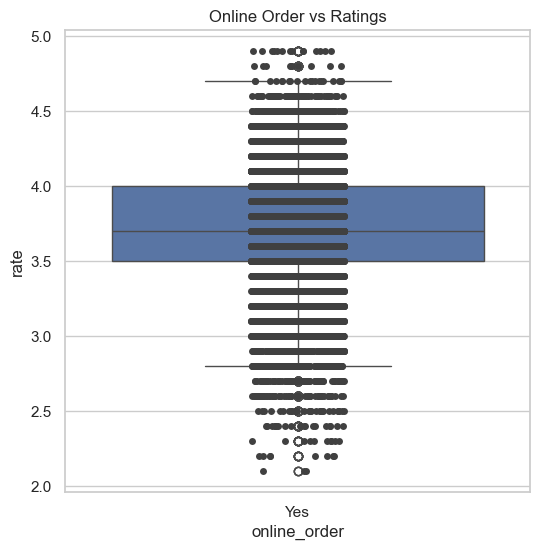

In [10]:
plt.figure(figsize=(6,6))
sns.boxplot(x="online_order", y="rate", data=df)
sns.stripplot(x="online_order", y="rate", data=df, color=".25", jitter=True)
plt.title("Online Order vs Ratings")
plt.show()

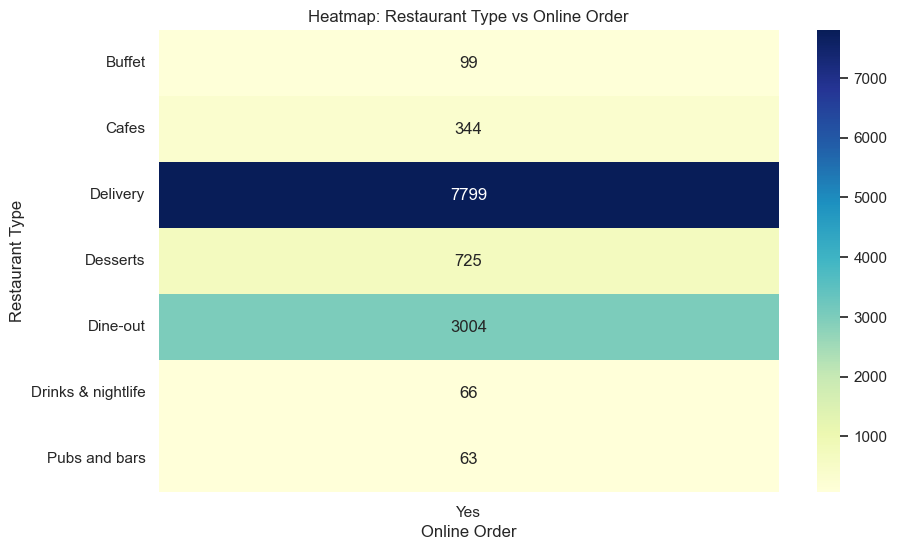

In [11]:
pivot_table = df.pivot_table(index="listed_intype", columns="online_order", aggfunc="size", fill_value=0)
plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Heatmap: Restaurant Type vs Online Order")
plt.xlabel("Online Order")
plt.ylabel("Restaurant Type")
plt.show()

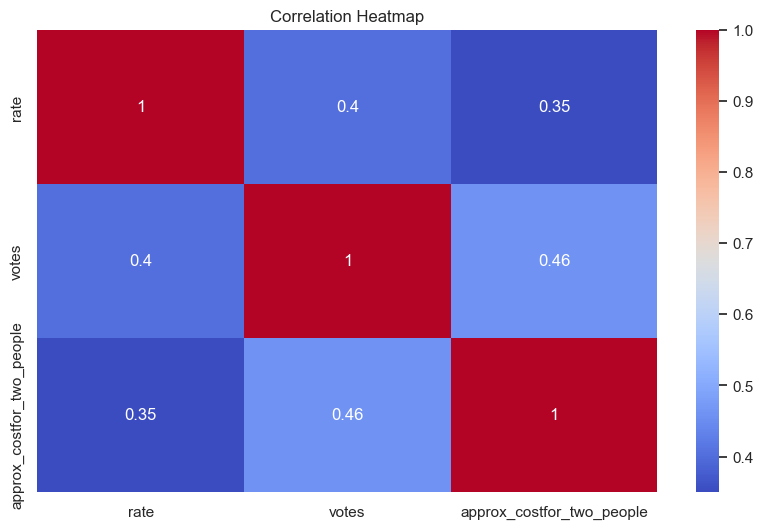

In [12]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

C:\Users\Nikhil Singh\anaconda3\envs\venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


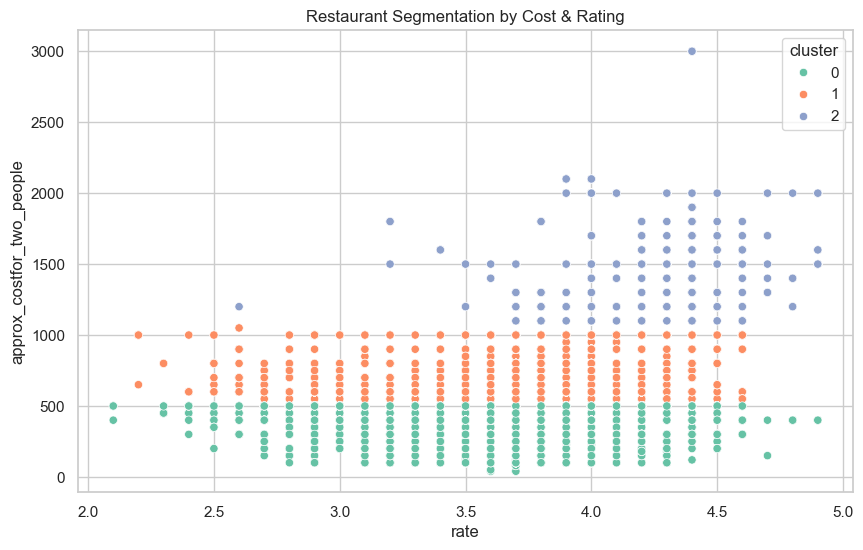

In [13]:
X = df[['rate','approx_costfor_two_people']].dropna()
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(10,6))
sns.scatterplot(x="rate", y="approx_costfor_two_people", hue="cluster", data=df, palette="Set2")
plt.title("Restaurant Segmentation by Cost & Rating")
plt.show()

In [14]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


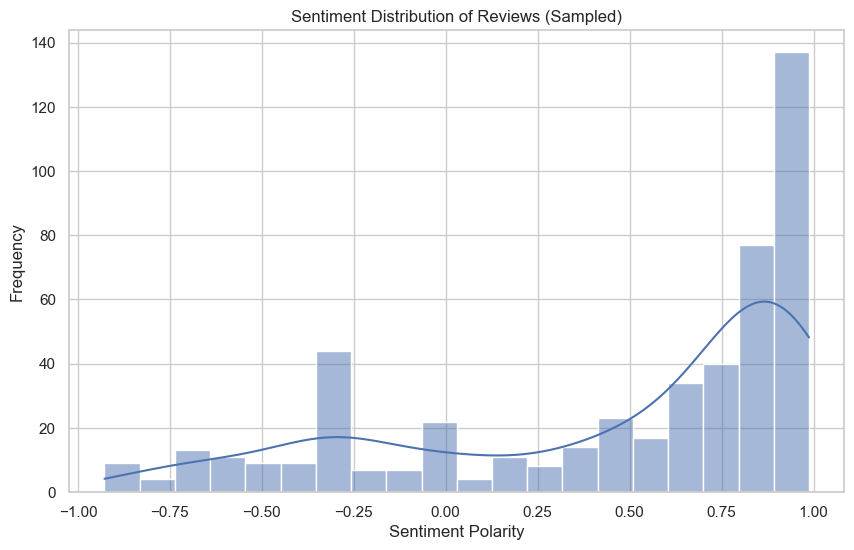

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Sample and clean
sample_df = df.sample(n=500, random_state=42)
sample_df['reviews_list'] = sample_df['reviews_list'].astype(str).str.slice(0, 300)

# Apply VADER sentiment
sample_df['sentiment'] = sample_df['reviews_list'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Plot
plt.figure(figsize=(10,6))
sns.histplot(sample_df['sentiment'], bins=20, kde=True)
plt.title("Sentiment Distribution of Reviews (Sampled)")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

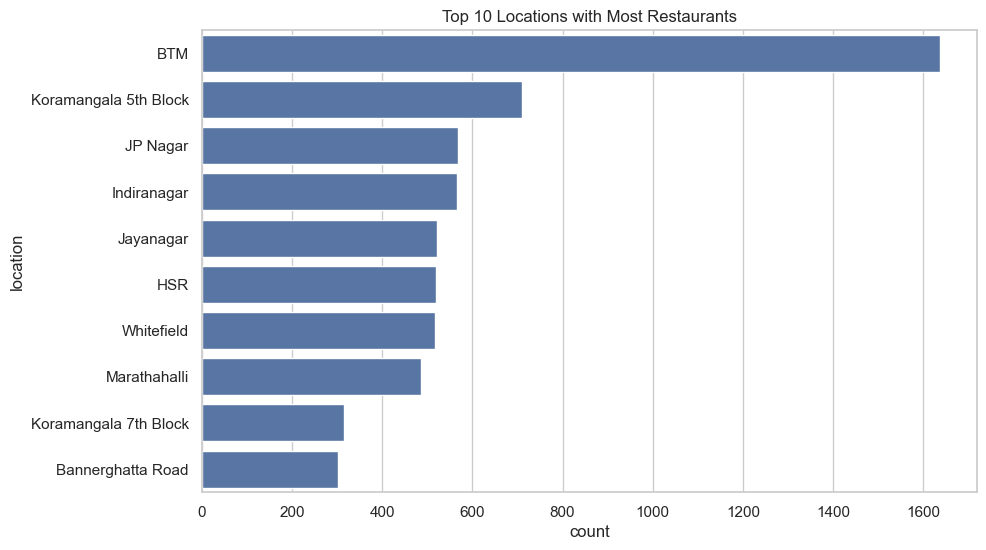

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(y="location", data=df, order=df['location'].value_counts().index[:10])
plt.title("Top 10 Locations with Most Restaurants")
plt.show()

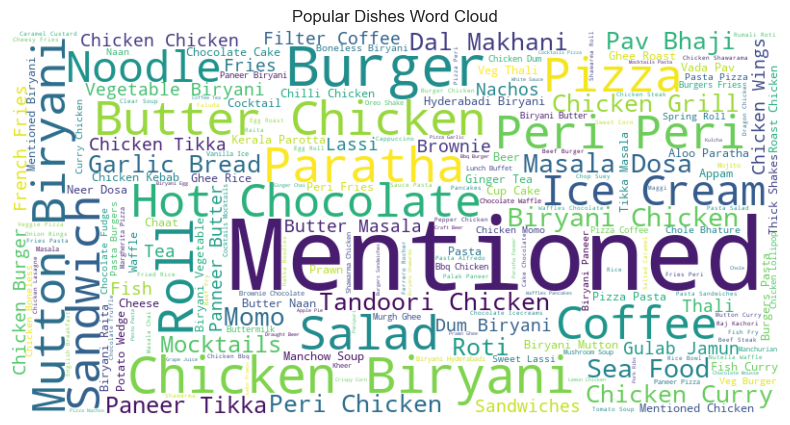

In [17]:
text = ' '.join(df['dish_liked'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Popular Dishes Word Cloud")
plt.show()

In [18]:
city_dropdown = widgets.Dropdown(options=df['location'].unique(), description="City:")
display(city_dropdown)

Dropdown(description='City:', options=('Banashankari', 'Kumaraswamy Layout', 'Vijay Nagar', 'Jayanagar', 'Basa…

### RECOMMENDATION SYSTEM

# 📊 Business Insights

- **Top Cuisines:** Identify which cuisines dominate the market.
- **Location Trends:** Highlight areas with the highest-rated restaurants.
- **Online Ordering Impact:** Compare ratings between restaurants with and without online ordering.
- **Cost vs Rating:** Discuss whether higher cost correlates with better ratings.
- **Customer Sentiment:** Summarize sentiment distribution from reviews.

These insights can guide Zomato in improving recommendations, marketing strategies, and customer engagement.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Select features for similarity
features = df[['rate', 'approx_costfor_two_people', 'votes']].fillna(0)

# Compute similarity matrix
similarity = cosine_similarity(features)

# Function to recommend restaurants based on index
def recommend(index, n=5):
    scores = list(enumerate(similarity[index]))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:n+1]
    return df.iloc[[i[0] for i in sorted_scores]][['name', 'rate', 'location', 'cuisines']]

# Example: recommend similar restaurants to restaurant at index 100
recommend(100)

,name,rate,location,cuisines
3531,Leon Grill,4.3,Koramangala 5th Block,"Burger, Fast Food"
801,Mad Over Donuts,3.9,Brigade Road,"Bakery, Desserts, Beverages"
1043,Mad Over Donuts,3.9,Brigade Road,"Bakery, Desserts, Beverages"
2474,Mad Over Donuts,3.9,Brigade Road,"Bakery, Desserts, Beverages"
2895,Mad Over Donuts,3.9,Brigade Road,"Bakery, Desserts, Beverages"


In [20]:
import folium

# Create a map centered on Bangalore (adjust if dataset is different)
map = folium.Map(location=[12.9716, 77.5946], zoom_start=12)

# Add markers (requires latitude/longitude columns if available)
if 'latitude' in df.columns and 'longitude' in df.columns:
    for _, row in df.dropna(subset=['latitude','longitude']).iterrows():
        folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(map)

map

In [21]:
city_dropdown = widgets.Dropdown(options=df['location'].unique(), description="City:")
rating_slider = widgets.FloatSlider(value=4.0, min=0, max=5, step=0.1, description="Min Rating")

def filter_data(city, rating):
    filtered = df[(df['location'] == city) & (df['rate'] >= rating)]
    display(filtered[['name', 'rate', 'location', 'cuisines']].head(10))

widgets.interact(filter_data, city=city_dropdown, rating=rating_slider)

interactive(children=(Dropdown(description='City:', options=('Banashankari', 'Kumaraswamy Layout', 'Vijay Naga…

<function __main__.filter_data(city, rating)>

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare features: include categorical variables with one-hot encoding
X = pd.get_dummies(df[['votes', 
                       'approx_costfor_two_people', 
                       'online_order', 
                       'book_table', 
                       'location', 
                       'rest_type', 
                       'cuisines']], drop_first=True)

# Target variable
y = df['rate'].fillna(df['rate'].median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate
print("Random Forest R² Score:", rf_model.score(X_test, y_test))

Random Forest R² Score: 0.8273191880657756


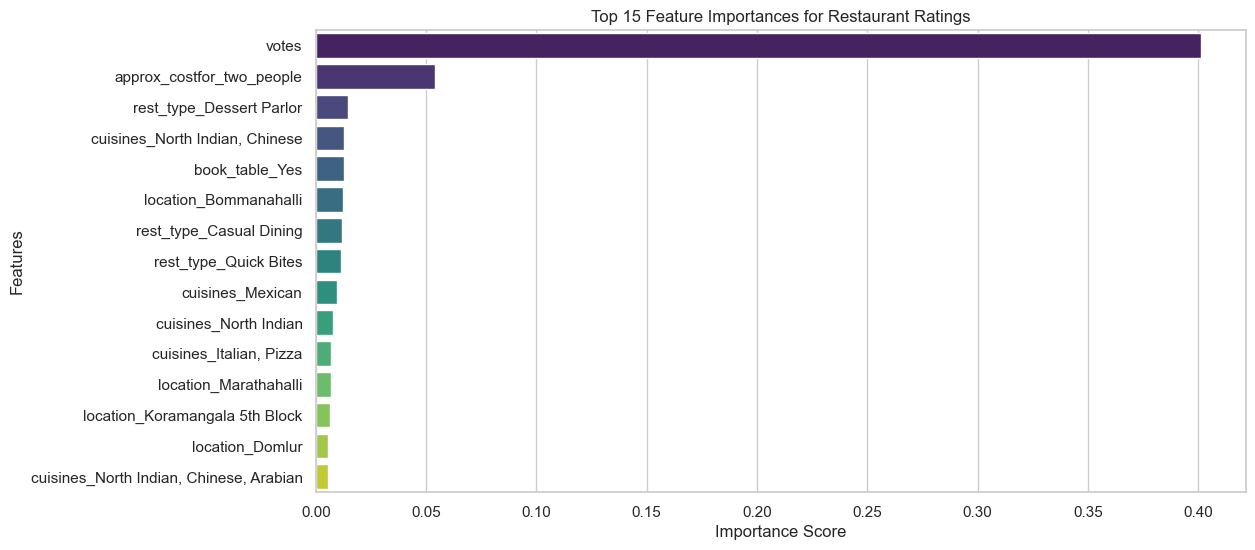

In [23]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
sns.barplot(
    x=importances[indices][:15], 
    y=X.columns[indices][:15], 
    hue=X.columns[indices][:15],   # Explicitly assign hue
    palette="viridis", 
    legend=False                   # Hide redundant legend
)
plt.title("Top 15 Feature Importances for Restaurant Ratings")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()